In [1]:
# -*- coding: UTF-8 -*-
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range, str, zip
import re
import os
from glob import glob
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from nlputils.features import preprocess_text
from nlputils.embedding import proj2d
from nlputils.visualize import basic_viz

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Extract emotions and sentiment from comments

In [2]:
# read in sentiment words
df = pd.read_csv("GermanPolarityClues-2012/GermanPolarityClues-Negative-21042012.tsv", sep="\t", header=None)
sent_neg = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("GermanPolarityClues-2012/GermanPolarityClues-Positive-21042012.tsv", sep="\t", header=None)
sent_pos = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("GermanPolarityClues-2012/GermanPolarityClues-Neutral-21042012.tsv", sep="\t", header=None)
sent_neu = set(preprocess_text(t) for t in df[0])
# read in emotion words and assign to 4 emotions
# https://www.microsoft.com/developerblog/2015/11/29/emotion-detection-and-recognition-from-text-using-deep-learning/
df = pd.read_csv("emotion_words/Ekel.txt", sep="\t", header=None)
emo_anger = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("emotion_words/Verachtung.txt", sep="\t", header=None)
emo_anger.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("emotion_words/Wut.txt", sep="\t", header=None)
emo_anger.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("emotion_words/Furcht.txt", sep="\t", header=None)
emo_fear = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("emotion_words/Freude.txt", sep="\t", header=None)
emo_happy = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("emotion_words/Ueberraschung.txt", sep="\t", header=None)
emo_happy.update(set(preprocess_text(t) for t in df[0]))
df = pd.read_csv("emotion_words/Trauer.txt", sep="\t", header=None)
emo_sad = set(preprocess_text(t) for t in df[0])
# define emotion emojis
# https://www.insight-centre.org/sites/default/files/publications/ianwood-emotionworkshop.pdf
emojis_happy = set("😀😃😄😁😆😅😂🤣☺😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤩😎😺😸😹😻😽🙌👏👍✌👌🎉❤💕💞💓💗💖♥")
emojis_sad = set("😞😔😟😕🙁☹😣😖😫😩😢😭😥😶😐😧😦😪😿🙀👎💔")
emojis_anger = set("😒😑😤😠😡🤬😾🖕💩👿")
emojis_fear = set("😱😳😨😰😵😧😮😲🙀")
emotions_list = ["happy", "sad", "fear", "anger", "-"]

def label_word_sent(w):
    sent_label = 0.
    if w in sent_neg:
        sent_label = -1.
    elif w in sent_pos:
        sent_label = +1.
    return sent_label

def label_word_emo(w):
    emo_label = "-"
    if w in emo_anger:
        emo_label = "anger"
    elif w in emo_fear:
        emo_label = "fear"
    elif w in emo_happy:
        emo_label = "happy"
    elif w in emo_sad:
        emo_label = "sad"
    return emo_label
    

In [40]:
comments = {}
comments_pp = {}
sent_scores = {}
emo_anger_scores = {}
emo_fear_scores = {}
emo_sad_scores = {}
emo_happy_scores = {}
emo_main_label = {}
fnames = sorted(glob("Kommentare/*.txt"))
for fnamef in fnames:
    fname = fnamef.split("/")[1].split(".")[0]
    print("##########")
    print(fname)
    print(len(fname)*"-")
    comments[fname] = {}
    comments_pp[fname] = {}
    sent_scores[fname] = {}
    emo_anger_scores[fname] = {}
    emo_fear_scores[fname] = {}
    emo_sad_scores[fname] = {}
    emo_happy_scores[fname] = {}
    emo_main_label[fname] = {}
    with open(fnamef) as f:
        for i, l in enumerate(f.readlines()):
            if l.strip():
                pp_l = preprocess_text(l)
                if pp_l:
                    comments[fname][i] = l
                    # based on the preprocessed words, get sentiment and word based emotion scores
                    pp_l = preprocess_text(l)
                    sent_scores[fname][i] = np.mean([label_word_sent(word) for word in pp_l.split()])
                    emotions = Counter([label_word_emo(word) for word in pp_l.split()])
                    # add scores based on emojis (from non-preprocessed text!)
                    char_counts = Counter(list(l))
                    for c in char_counts:
                        if len(c.encode("ascii", "backslashreplace")) > 5:
                            pp_l += " " + " ".join(char_counts[c]*[c])
                            if c in emojis_anger:
                                emotions["anger"] += char_counts[c]
                            elif c in emojis_fear:
                                emotions["fear"] += char_counts[c]
                            elif c in emojis_happy:
                                emotions["happy"] += char_counts[c]
                            elif c in emojis_sad:
                                emotions["sad"] += char_counts[c]
                    comments_pp[fname][i] = pp_l
                    n_tokens = len(pp_l.split())
                    emotions["-"] = 0
                    emo_main_label[fname][i] = max(emotions, key=emotions.get)
                    emo_anger_scores[fname][i] = emotions["anger"]/n_tokens
                    emo_fear_scores[fname][i] = emotions["fear"]/n_tokens
                    emo_sad_scores[fname][i] = emotions["sad"]/n_tokens
                    emo_happy_scores[fname][i] = emotions["happy"]/n_tokens
    print("%i comments in total" % len(comments[fname]))
    sent = np.array(list(sent_scores[fname].values()))
    emos = np.array(list(emo_main_label[fname].values()))
    print("sentiment: %.1f%% positive, %.1f%% negative, and %.1f%% neutral comments" % (100*np.sum(sent>0)/len(comments[fname]), 100*np.sum(sent<0)/len(comments[fname]), 100*np.sum(sent==0)/len(comments[fname])))
    print("emotions: %.1f%% anger, %.1f%% fear, %.1f%% sad, %.1f%% happy, %.1f%% neutral comments\n" % (100*np.sum(emos=="anger")/len(comments[fname]), 100*np.sum(emos=="fear")/len(comments[fname]), 100*np.sum(emos=="sad")/len(comments[fname]), 100*np.sum(emos=="happy")/len(comments[fname]), 100*np.sum(emos=="-")/len(comments[fname])))
    print("sentiment scores: [%.3f, %.3f]; %.3f +/- %.3f" % (max(sent_scores[fname].values()), min(sent_scores[fname].values()), np.mean(list(sent_scores[fname].values())), np.std(list(sent_scores[fname].values()))))
    i = max(sorted(comments[fname], key=sent_scores[fname].get, reverse=True)[:10], key=lambda x: len(comments_pp[fname][x]))
    print("most positive comment (%.3f):" % sent_scores[fname][i])
    print(comments[fname][i])
    i = max(sorted(comments[fname], key=sent_scores[fname].get)[:10], key=lambda x: len(comments_pp[fname][x]))
    print("most negative comment (%.3f):" % sent_scores[fname][i])
    print(comments[fname][i])
    print("anger scores: [%.3f, %.3f]; %.3f +/- %.3f" % (max(emo_anger_scores[fname].values()), min(emo_anger_scores[fname].values()), np.mean(list(emo_anger_scores[fname].values())), np.std(list(emo_anger_scores[fname].values()))))
    i = max(sorted(comments[fname], key=emo_anger_scores[fname].get, reverse=True)[:10], key=lambda x: len(comments_pp[fname][x]))
    print("most angry comment (%.3f):" % emo_anger_scores[fname][i])
    print(comments[fname][i])
    i = max(sorted(comments[fname], key=emo_fear_scores[fname].get, reverse=True)[:10], key=lambda x: len(comments_pp[fname][x]))
    print("fear scores: [%.3f, %.3f]; %.3f +/- %.3f" % (max(emo_fear_scores[fname].values()), min(emo_fear_scores[fname].values()), np.mean(list(emo_fear_scores[fname].values())), np.std(list(emo_fear_scores[fname].values()))))
    print("most afraid comment (%.3f):" % emo_fear_scores[fname][i])
    print(comments[fname][i])
    i = max(sorted(comments[fname], key=emo_sad_scores[fname].get, reverse=True)[:10], key=lambda x: len(comments_pp[fname][x]))
    print("sad scores: [%.3f, %.3f]; %.3f +/- %.3f" % (max(emo_sad_scores[fname].values()), min(emo_sad_scores[fname].values()), np.mean(list(emo_sad_scores[fname].values())), np.std(list(emo_sad_scores[fname].values()))))
    print("most sad comment (%.3f):" % emo_sad_scores[fname][i])
    print(comments[fname][i])
    i = max(sorted(comments[fname], key=emo_happy_scores[fname].get, reverse=True)[:10], key=lambda x: len(comments_pp[fname][x]))
    print("happy scores: [%.3f, %.3f]; %.3f +/- %.3f" % (max(emo_happy_scores[fname].values()), min(emo_happy_scores[fname].values()), np.mean(list(emo_happy_scores[fname].values())), np.std(list(emo_happy_scores[fname].values()))))
    print("most happy comment (%.3f):" % emo_happy_scores[fname][i])
    print(comments[fname][i])

##########
001 eishockey
-------------
837 comments in total
sentiment: 53.8% positive, 22.1% negative, and 24.1% neutral comments
emotions: 9.0% anger, 0.6% fear, 2.5% sad, 52.8% happy, 35.1% neutral comments

sentiment scores: [1.000, -1.000]; 0.138 +/- 0.306
most positive comment (1.000):
Hammer Leistung 👍👍😝Herzlichen Glückwunsch 🎈🎉

most negative comment (-0.600):
Mario Bratfisch schlechter Verlierer? 🤔 Frust?

anger scores: [0.600, 0.000]; 0.012 +/- 0.046
most angry comment (0.471):
Des drecks Russenpack ist doch voll bis oben hin🤬🤬🤬🤬🤬😠😠😠

fear scores: [0.100, 0.000]; 0.001 +/- 0.007
most afraid comment (0.028):
Bin ja schon lange nicht mehr  nachts wegen einer TV übertragung aufgestenden. Früher war es die Mondlandung, Cassius Clay oder Schumi. Ich muss aber sagen Respekt vor den Eishockey Cracks hat sich gelohnt den tollen Kampf um Gold anzuschauen. Wir waren so dicht dran.😧 Was ich auch  super finde, sind die Trikots der Deutschen Eishockey  Nationalmannschaft, Schwarz Rot Gold

8328 comments in total
sentiment: 18.3% positive, 12.4% negative, and 69.3% neutral comments
emotions: 2.2% anger, 1.0% fear, 1.9% sad, 47.5% happy, 47.3% neutral comments

sentiment scores: [1.000, -1.000]; 0.019 +/- 0.196
most positive comment (1.000):
Klassiker 😅🤣

most negative comment (-1.000):
Kein Geheimnis 🤷🏽‍♂️

anger scores: [1.000, 0.000]; 0.006 +/- 0.046
most angry comment (0.500):
Waschlappen😂

fear scores: [0.750, 0.000]; 0.003 +/- 0.030
most afraid comment (0.500):
Christinka Black😱😱

sad scores: [1.000, 0.000]; 0.005 +/- 0.040
most sad comment (0.500):
Jasmin Sz alter ich kotz gleiche 😭😭😭😭😭😭

happy scores: [1.000, 0.000]; 0.154 +/- 0.202
most happy comment (1.000):
romantisch 🤣🤣

##########
011 meinung spahn
-----------------
4026 comments in total
sentiment: 27.5% positive, 45.0% negative, and 27.5% neutral comments
emotions: 27.7% anger, 1.6% fear, 4.6% sad, 19.9% happy, 46.2% neutral comments

sentiment scores: [1.000, -1.000]; -0.021 +/- 0.177
most positive comment 

4167 comments in total
sentiment: 23.6% positive, 46.1% negative, and 30.3% neutral comments
emotions: 20.1% anger, 3.7% fear, 3.6% sad, 22.7% happy, 49.9% neutral comments

sentiment scores: [1.000, -1.000]; -0.055 +/- 0.202
most positive comment (1.000):
Vollkommen richtig

most negative comment (-1.000):
BLÖDSINN 😜😜😜

anger scores: [1.000, 0.000]; 0.037 +/- 0.117
most angry comment (1.000):
Schwachsinn!!!!

fear scores: [0.750, 0.000]; 0.006 +/- 0.034
most afraid comment (0.619):
...na ja sonst scheinen wir keine Sorgen zu haben😳😳😳😳😳😳😳😳😳😳😳😳

sad scores: [0.750, 0.000]; 0.006 +/- 0.034
most sad comment (0.375):
Ich bekomme schon wieder Kopfschmerzen. 😣😣😣

happy scores: [1.000, 0.000]; 0.039 +/- 0.100
most happy comment (0.875):
DAS ist die Frauenbeauftragte?!  🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣

##########
021 pizza obdachlose
--------------------
189 comments in total
sentiment: 59.3% positive, 14.8% negative, and 25.9% neutral comments
emotions: 6.3% anger, 0.5% fear, 3.7% sad, 57.7% hap

5147 comments in total
sentiment: 18.6% positive, 9.7% negative, and 71.7% neutral comments
emotions: 1.2% anger, 0.8% fear, 1.1% sad, 46.8% happy, 50.0% neutral comments

sentiment scores: [1.000, -1.000]; 0.033 +/- 0.185
most positive comment (1.000):
😂😂 ja genau 😂😂

most negative comment (-1.000):
Kein Problem🤣

anger scores: [1.000, 0.000]; 0.004 +/- 0.035
most angry comment (0.400):
Hahahaha 🖕🏼🖕🏼

fear scores: [0.545, 0.000]; 0.003 +/- 0.028
most afraid comment (0.400):
Patrick Weber das will ich haben 😳😳😳😳

sad scores: [0.667, 0.000]; 0.003 +/- 0.031
most sad comment (0.556):
Lena Hornung ich sterbeeeee 😩😩😩😩😩

happy scores: [1.000, 0.000]; 0.147 +/- 0.201
most happy comment (1.000):
Herrlich 😂😂😂

##########
029 dauerfrost kommt
--------------------
2094 comments in total
sentiment: 20.8% positive, 17.3% negative, and 61.9% neutral comments
emotions: 5.2% anger, 6.8% fear, 7.4% sad, 28.2% happy, 52.4% neutral comments

sentiment scores: [1.000, -1.000]; 0.009 +/- 0.216
most positi

1287 comments in total
sentiment: 27.0% positive, 48.1% negative, and 24.9% neutral comments
emotions: 21.7% anger, 4.0% fear, 11.5% sad, 20.7% happy, 42.0% neutral comments

sentiment scores: [1.000, -1.000]; -0.033 +/- 0.176
most positive comment (0.500):
Tolgay Gülşen mehr Menschen mehr Einnahmen 👍

most negative comment (-0.667):
Traurig. Armes Deutschland.

anger scores: [1.000, 0.000]; 0.025 +/- 0.083
most angry comment (0.500):
Ich könnte kotzen. 😡

fear scores: [0.400, 0.000]; 0.004 +/- 0.024
most afraid comment (0.154):
Keine Sorge, Sarah, das Kinderkriegen übernehmen andere für dich, die keine Angst haben...

sad scores: [1.000, 0.000]; 0.019 +/- 0.083
most sad comment (0.667):
Merkelpolitik leider 😞

happy scores: [1.000, 0.000]; 0.020 +/- 0.063
most happy comment (0.649):
Jetzt kommt jeder mit dem Butter an! 😂😂😂😂😂😂😂😂😂😆🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 dann kostet das Butter eben 1,80€ und Margarine 99cent und jetzt?

##########
037 meth augen
--------------
2236 comments in total

2818 comments in total
sentiment: 20.7% positive, 11.7% negative, and 67.6% neutral comments
emotions: 2.6% anger, 0.4% fear, 0.9% sad, 48.7% happy, 47.5% neutral comments

sentiment scores: [1.000, -1.000]; 0.030 +/- 0.183
most positive comment (1.000):
Ja richtig! 😂

most negative comment (-0.500):
In dem Falle ergibt Minus & Minus aber kein Plus xD

anger scores: [1.000, 0.000]; 0.006 +/- 0.040
most angry comment (0.333):
Fra Nk besser still sein 🖕🖕🖕😂

fear scores: [0.500, 0.000]; 0.001 +/- 0.015
most afraid comment (0.364):
Weißt du nicht wer der Typ Ist?????😱😱😱😱

sad scores: [0.500, 0.000]; 0.002 +/- 0.023
most sad comment (0.222):
Aha Und uns haste schon wieder vergessen.....😭😛

happy scores: [1.000, 0.000]; 0.143 +/- 0.185
most happy comment (0.800):
Klar Schatzi 😘😘😂😂😂😂😂😂

##########
047 petition spahn
------------------
1128 comments in total
sentiment: 30.0% positive, 45.7% negative, and 24.3% neutral comments
emotions: 20.8% anger, 1.8% fear, 5.1% sad, 20.6% happy, 51.7% neut

2769 comments in total
sentiment: 15.7% positive, 13.7% negative, and 70.6% neutral comments
emotions: 1.6% anger, 1.5% fear, 0.8% sad, 35.6% happy, 60.4% neutral comments

sentiment scores: [1.000, -1.000]; 0.014 +/- 0.178
most positive comment (1.000):
Unbedingt 😍 😍 😍 😍 😍

most negative comment (-0.500):
Achtung Holzkohle ist ungesund!

anger scores: [1.000, 0.000]; 0.004 +/- 0.032
most angry comment (0.250):
Christian Burkard kleiner Snack

fear scores: [0.750, 0.000]; 0.004 +/- 0.037
most afraid comment (0.375):
Denny Scheubeck😱😱😱😋😋😋

sad scores: [1.000, 0.000]; 0.002 +/- 0.031
most sad comment (0.583):
Noch 4 1/2 Wochen 😣😣😣😣😣😣😣

happy scores: [1.000, 0.000]; 0.105 +/- 0.180
most happy comment (1.000):
Fabelhaft 😅

##########
055 biomuell millionen
----------------------
1463 comments in total
sentiment: 15.4% positive, 25.2% negative, and 59.5% neutral comments
emotions: 8.1% anger, 2.7% fear, 2.3% sad, 28.2% happy, 58.9% neutral comments

sentiment scores: [1.000, -1.000]; -0.023

3712 comments in total
sentiment: 20.8% positive, 15.5% negative, and 63.6% neutral comments
emotions: 3.8% anger, 0.8% fear, 0.3% sad, 47.2% happy, 47.9% neutral comments

sentiment scores: [1.000, -1.000]; 0.027 +/- 0.197
most positive comment (1.000):
Ja klar 😂😂😂

most negative comment (-0.600):
Max Kahl ne... aber abnehmen😂

anger scores: [1.000, 0.000]; 0.008 +/- 0.041
most angry comment (0.667):
Lukas du Arsch🖕🖕🖕

fear scores: [0.667, 0.000]; 0.003 +/- 0.029
most afraid comment (0.375):
Gerne aber kostet 300 euro🙀🙀🙀

sad scores: [0.500, 0.000]; 0.001 +/- 0.016
most sad comment (0.133):
Cathrin du blöde Kuh 😭😖 Mika ist nicht fett nur mollig😂😂😂

happy scores: [1.000, 0.000]; 0.127 +/- 0.175
most happy comment (1.000):
Perfekt 🤣👍

##########
064 freunde 60 jahre
--------------------
4026 comments in total
sentiment: 24.8% positive, 9.5% negative, and 65.7% neutral comments
emotions: 1.1% anger, 0.5% fear, 0.8% sad, 61.1% happy, 36.5% neutral comments

sentiment scores: [1.000, -1.00

3247 comments in total
sentiment: 18.3% positive, 15.2% negative, and 66.5% neutral comments
emotions: 3.7% anger, 0.5% fear, 0.6% sad, 44.0% happy, 51.3% neutral comments

sentiment scores: [1.000, -1.000]; 0.024 +/- 0.195
most positive comment (1.000):
Hoffentlich 😂

most negative comment (-0.500):
100 euro fast verloren für nichts 😂😂😂

anger scores: [1.000, 0.000]; 0.008 +/- 0.046
most angry comment (0.600):
😡 du bist langweilig.... 😤

fear scores: [0.500, 0.000]; 0.001 +/- 0.018
most afraid comment (0.231):
Laura Penzinger Daniel Pointner😂do griagd da Schedo an Herzinfakt 😱😱😱

sad scores: [0.500, 0.000]; 0.001 +/- 0.016
most sad comment (0.182):
Sehr geil!!!! Leider hab' ich im Moment null Platz dafür 😩

happy scores: [1.000, 0.000]; 0.120 +/- 0.174
most happy comment (1.000):
Geil!!😂😂😂😂

##########
074 merkel ueber seehofer
-------------------------
2119 comments in total
sentiment: 29.0% positive, 42.3% negative, and 28.7% neutral comments
emotions: 16.6% anger, 2.2% fear, 3.9% s

2542 comments in total
sentiment: 21.0% positive, 23.6% negative, and 55.4% neutral comments
emotions: 4.4% anger, 0.9% fear, 0.9% sad, 48.2% happy, 45.6% neutral comments

sentiment scores: [1.000, -1.000]; 0.005 +/- 0.204
most positive comment (1.000):
Respekt 👌👌👌👌👌

most negative comment (-1.000):
Schwach 🙄🙄😂😂😂

anger scores: [1.000, 0.000]; 0.012 +/- 0.063
most angry comment (0.500):
Nicht schlecht

fear scores: [0.375, 0.000]; 0.001 +/- 0.014
most afraid comment (0.154):
Maxi vllt sollten wir uns sowas in zukunft anschaffe, weniger gefahr vorm unfall

sad scores: [0.667, 0.000]; 0.002 +/- 0.020
most sad comment (0.182):
60, traurig sowas. Nicht mal mehr das können die heutzutage 😣

happy scores: [1.000, 0.000]; 0.130 +/- 0.182
most happy comment (1.000):
Respekt 👌👌👌👌👌

##########
083 dildo drohne
----------------
3016 comments in total
sentiment: 13.6% positive, 16.8% negative, and 69.5% neutral comments
emotions: 2.1% anger, 1.3% fear, 0.5% sad, 50.3% happy, 45.9% neutral comment

432 comments in total
sentiment: 20.8% positive, 52.5% negative, and 26.6% neutral comments
emotions: 22.7% anger, 5.8% fear, 35.2% sad, 13.2% happy, 23.1% neutral comments

sentiment scores: [0.400, -1.000]; -0.065 +/- 0.185
most positive comment (0.273):
😭 oh mein Gott wie schrecklich,  mein herzliches Beileid an den Eltern , ich wünsche sehr viel viel Kraft . Ruhe in Frieden kleiner Engel.

most negative comment (-0.571):
Grauenvoll....schlimmster Alptraum überhaupt 🙈 das arme Kind

anger scores: [1.000, 0.000]; 0.042 +/- 0.104
most angry comment (0.364):
Ruhe in Frieden kleiner Engel....so sinnlos, so furchtbar und grausam

fear scores: [0.833, 0.000]; 0.011 +/- 0.061
most afraid comment (0.120):
Oh mein Gott, werde schon beim lesen des Artikels traurig 😪😪😪😪 scheisse😱😱😱 mein Beileid an die Familie 🥀😪

sad scores: [0.750, 0.000]; 0.085 +/- 0.137
most sad comment (0.600):
Mein Beileid, so traurig 😞

happy scores: [0.333, 0.000]; 0.017 +/- 0.038
most happy comment (0.154):
Furchbar 😢r

920 comments in total
sentiment: 25.5% positive, 38.6% negative, and 35.9% neutral comments
emotions: 22.6% anger, 1.5% fear, 2.2% sad, 22.6% happy, 51.1% neutral comments

sentiment scores: [1.000, -1.000]; -0.024 +/- 0.211
most positive comment (1.000):
Absolut richtig👍🏻

most negative comment (-1.000):
Lächerlich 🤦🏻‍♂️😂😂😂😂

anger scores: [1.000, 0.000]; 0.035 +/- 0.114
most angry comment (0.500):
Möchtegern Deutscher...

fear scores: [0.167, 0.000]; 0.002 +/- 0.011
most afraid comment (0.067):
Was macht der in Bundestag der soll abhauen und die Claudia R gleich mit..Arrrrrrrrrrrr

sad scores: [0.333, 0.000]; 0.003 +/- 0.022
most sad comment (0.214):
Dann soll Cem die Artikel und Bücher von Yücel einmal lesen... 😣😣😣

happy scores: [1.000, 0.000]; 0.049 +/- 0.136
most happy comment (0.714):
Endlich mal....Glückwunsch 👍👍👍👍

##########
101 merkel tafel
----------------
1755 comments in total
sentiment: 27.5% positive, 48.1% negative, and 24.4% neutral comments
emotions: 24.2% anger, 3.0

968 comments in total
sentiment: 32.0% positive, 44.1% negative, and 23.9% neutral comments
emotions: 22.7% anger, 2.7% fear, 6.3% sad, 23.3% happy, 44.9% neutral comments

sentiment scores: [1.000, -1.000]; -0.013 +/- 0.184
most positive comment (0.500):
Meinen absoluten  Respekt liebe Frau  Böhm

most negative comment (-0.667):
Nein gegen altersarmut

anger scores: [1.000, 0.000]; 0.025 +/- 0.083
most angry comment (0.400):
Eine Schande. .Ich könnte kotzen

fear scores: [0.167, 0.000]; 0.002 +/- 0.010
most afraid comment (0.071):
Rainer Landefeld leiden Sie unter Demenz oder was stimmt nicht mit Ihnen? Bitte suchen Sie einen Arzt auf, Facebook kann Ihnen da leider nicht helfen, gute Besserung ☘

sad scores: [1.000, 0.000]; 0.008 +/- 0.055
most sad comment (0.182):
Überwiegend richtig aber eine alte Dame friert leider etwas schneller 😕

happy scores: [1.000, 0.000]; 0.032 +/- 0.101
most happy comment (0.667):
Anne rose.RESPEKT.DU BIST UNIKAT💖💖💖💖💖💖💖💖👎

##########
109 jobs ohne menschen

794 comments in total
sentiment: 29.8% positive, 16.9% negative, and 53.3% neutral comments
emotions: 6.7% anger, 1.0% fear, 1.8% sad, 31.0% happy, 59.6% neutral comments

sentiment scores: [1.000, -1.000]; 0.039 +/- 0.251
most positive comment (1.000):
Glückwunsch ☺

most negative comment (-0.500):
Was für ein Blödsinn.

anger scores: [1.000, 0.000]; 0.009 +/- 0.053
most angry comment (0.200):
So ein Blödsinn. Plötzlich sind alle nur noch böse und gemein. Scheint ansteckend zu sein.

fear scores: [0.500, 0.000]; 0.001 +/- 0.019
most afraid comment (0.026):
Typische Bild Kolumne...Hauptsache einer Hängt. Ausländischer Nachname, Bremer Plattenbau...Sportwagen, Privat Jet...1000 Leute die für IHN arbeiten. Jeder einzelne Cent sei IHM gegönnt und seinen Mitarbeitern. Das sehen halt viele nicht, das wirklich Arbeit+Risiko dahinter steckt.

sad scores: [0.333, 0.000]; 0.002 +/- 0.021
most sad comment (0.077):
Ich gönne jedem der hart und ehrlich arbeitet das er zu Wohlstand kommt. Er tut ja

1337 comments in total
sentiment: 22.5% positive, 47.1% negative, and 30.4% neutral comments
emotions: 26.8% anger, 2.8% fear, 4.8% sad, 19.4% happy, 46.2% neutral comments

sentiment scores: [1.000, -1.000]; -0.039 +/- 0.166
most positive comment (0.500):
Sehr guter Beitrag,den man nur unterstützen kann

most negative comment (-0.600):
Was für eine dumme Marionette!!

anger scores: [1.000, 0.000]; 0.038 +/- 0.101
most angry comment (0.533):
Alles gewollt, Gabriel sagte Pack wo sitzt der Pack 😡😡😡😡😡😡

fear scores: [0.300, 0.000]; 0.003 +/- 0.019
most afraid comment (0.182):
Bei dem unterbelichteten Personal unserer Regierung wird mir Angst und Bange...

sad scores: [0.600, 0.000]; 0.005 +/- 0.028
most sad comment (0.125):
Guck was deinen volk weh tut und nicht was Putin weh tun könnte! Elendige Heuchler/in

happy scores: [1.000, 0.000]; 0.031 +/- 0.092
most happy comment (0.571):
Flintenmuschi geh scheissen! 😂😂😂😂

##########
125 rentnerin tafel
-------------------
691 comments in total


842 comments in total
sentiment: 31.6% positive, 44.9% negative, and 23.5% neutral comments
emotions: 19.0% anger, 3.0% fear, 5.0% sad, 26.0% happy, 47.0% neutral comments

sentiment scores: [1.000, -0.500]; 0.002 +/- 0.172
most positive comment (0.600):
Max Müller Sehr guter Beitrag

most negative comment (-0.385):
Sara Nemer  Nonne in Luxemburg hart gearbeitet,was andere nicht tun im Fetzen 👎🏿👎🏿👎🏿👎🏿👎🏿😡

anger scores: [0.333, 0.000]; 0.016 +/- 0.038
most angry comment (0.179):
Wenn Sie so furchtbar intolerant sein wollten, dann ziehen Sie doch vielleicht einfach in ein anderen Land, wo die Menschen und die Gesetze auch allgemein furchtbar intolerant sind.

fear scores: [0.273, 0.000]; 0.002 +/- 0.015
most afraid comment (0.059):
Die Muslime fordern Kinderehe Tierschächten Vielehe Ehrenmorde usw es wird Zeit  gegen diesen Gewaltbereiten Terror Glauben  vorzugehen .

sad scores: [0.312, 0.000]; 0.004 +/- 0.021
most sad comment (0.208):
Sara Nemer  Nonne in Luxemburg hart gearbeitet,was 

927 comments in total
sentiment: 23.1% positive, 43.3% negative, and 33.7% neutral comments
emotions: 19.1% anger, 7.1% fear, 4.5% sad, 21.3% happy, 48.0% neutral comments

sentiment scores: [1.000, -1.000]; -0.040 +/- 0.197
most positive comment (0.500):
Voll die Reife Lösung du Pfosten

most negative comment (-0.750):
Müssen muss man garnichts

anger scores: [1.000, 0.000]; 0.033 +/- 0.108
most angry comment (0.750):
Dumm, dümmer, Deutschland 😡

fear scores: [0.500, 0.000]; 0.006 +/- 0.029
most afraid comment (0.143):
Barbara schau, Kollegen mit dem Tod bedrohen stört nicht den Betriebsfrieden👐🏽😂

sad scores: [0.600, 0.000]; 0.007 +/- 0.037
most sad comment (0.250):
Traurig traurig wie ist denn so was möglich?

happy scores: [1.000, 0.000]; 0.035 +/- 0.094
most happy comment (0.448):
Wäre so mega witzig wenn er jetzt erste Woche wieder in der Arbeit einen Anschlag verüben würde 😂😂😂😂😂😂😂😂😂😂😂😂

##########
140 sandsturm
-------------
469 comments in total
sentiment: 17.3% positive, 19.2%

## Visualization

In [4]:
# get all comments as lists of lists
sentences = []
for fname in comments_pp:
    for i in comments_pp[fname]:
        sentences.append(comments_pp[fname][i].split())

In [5]:
# train word2vec model
model = Word2Vec(sentences, size=50, window=10, min_count=3, workers=4)
word_vectors = model.wv
del model
word_vectors.init_sims(replace=True)

In [6]:
word_vectors.most_similar(positive=['🙈'])

[('🙊', 0.7755732536315918),
 ('😅', 0.7746701836585999),
 ('🙄', 0.6647796630859375),
 ('😜', 0.6192872524261475),
 ('😂', 0.6177088022232056),
 ('🤔', 0.5721880197525024),
 ('🙉', 0.5650612115859985),
 ('\U0001f92a', 0.5523953437805176),
 ('😏', 0.5502488017082214),
 ('😝', 0.5470948815345764)]

In [28]:
# compute similarities between sentences
def sentence_sim(x, y):
    """
    cosine similarity between the average word embeddings of x and y (both lists of words)
    """
    vec_x = np.sum([word_vectors[word] for word in x if word in word_vectors], axis=0)
    vec_y = np.sum([word_vectors[word] for word in y if word in word_vectors], axis=0)
    if isinstance(vec_x, float) or isinstance(vec_y, float):
        return 0.  # no dot product with no vectors
    return np.dot(vec_x, vec_y) / (np.linalg.norm(vec_x) * np.linalg.norm(vec_y))

def sim_mat(fname, ids):
    print("computing similarity matrix for %i comments" % len(ids))
    S = np.zeros((len(ids), len(ids)))
    for i in range(len(ids)):
        if not i % 100:
            print("Processed %i/%i texts" % (i, len(ids)))
        for j in range(i+1):
            similarity = sentence_sim(comments_pp[fname][ids[i]].split(), comments_pp[fname][ids[j]].split())
            if np.isnan(similarity):
                print(comments_pp[fname][ids[i]].split())
                print(comments_pp[fname][ids[j]].split())
            S[i, j], S[j, i] = similarity, similarity
    # scale to be between 0 and 1
    S -= S.min()
    S /= S.max()
    return S

computing similarity matrix for 5000 comments
Processed 0/5000 texts
Processed 100/5000 texts
Processed 200/5000 texts
Processed 300/5000 texts
Processed 400/5000 texts
Processed 500/5000 texts
Processed 600/5000 texts
Processed 700/5000 texts
Processed 800/5000 texts
Processed 900/5000 texts
Processed 1000/5000 texts
Processed 1100/5000 texts
Processed 1200/5000 texts
Processed 1300/5000 texts
Processed 1400/5000 texts
Processed 1500/5000 texts
Processed 1600/5000 texts
Processed 1700/5000 texts
Processed 1800/5000 texts
Processed 1900/5000 texts
Processed 2000/5000 texts
Processed 2100/5000 texts
Processed 2200/5000 texts
Processed 2300/5000 texts
Processed 2400/5000 texts
Processed 2500/5000 texts
Processed 2600/5000 texts
Processed 2700/5000 texts
Processed 2800/5000 texts
Processed 2900/5000 texts
Processed 3000/5000 texts
Processed 3100/5000 texts
Processed 3200/5000 texts
Processed 3300/5000 texts
Processed 3400/5000 texts
Processed 3500/5000 texts
Processed 3600/5000 texts
Proc

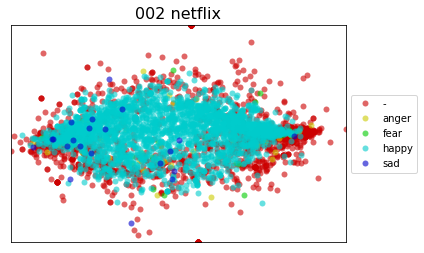

In [32]:
fname = fnames[1]
ids = np.random.permutation(list(comments_pp[fname]))[:3000]
S = sim_mat(fname, ids)
x, y = proj2d(S, use_tsne=True, verbose=True)
basic_viz(ids, emo_main_label[fname], x, y, dict(zip(emotions_list, emotions_list)), fname)